In [1]:
# Copernicus Marine Service API (API hat viele oz Daten)
import copernicusmarine

# mehr-D Arrays
import xarray as xr
# hat Fortschrittsbalken im Terminal / Jupyter-Notebook-Zelle zur Transparenz zb-beim Herunterladen von Copernicus Marine API Daten
import tqdm
# macht Dateipfade plattformunabhängig verwaltbar (Windows / Linux)
from pathlib import Path

ModuleNotFoundError: No module named 'copernicusmarine'

In [2]:
ds_my = copernicusmarine.open_dataset(
    dataset_id="cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D",
    service="arco-geo-series",
)
ds_my

INFO - 2024-11-08T09:33:51Z - Dataset version was not specified, the latest one was selected: "202112"
INFO - 2024-11-08T09:33:51Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-11-08T09:33:51Z - You forced selection of service: arco-geo-series


<xarray.Dataset>
Dimensions:         (time: 11115, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
    lat_bnds        (latitude, nv) float32 ...
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
    lon_bnds        (longitude, nv) float32 ...
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
  * time            (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2023-06-07
Data variables:
    adt             (time, latitude, longitude) float64 ...
    err_sla         (time, latitude, longitude) float64 ...
    err_ugosa       (time, latitude, longitude) float64 ...
    err_vgosa       (time, latitude, longitude) float64 ...
    flag_ice        (time, latitude, longitude) float64 ...
    sla             (time, latitude, longitude) float64 ...
    tpa_correction  (time) float64 ...
    ugos            (time, latitude, longitude) float64 ...
    ugosa           (time, latitude, longitude) float64 ...
    vgos            (time, latitude, longitude) float64 ...
    vgosa           (time, latitude, longitude) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [3]:
ds_nrt = copernicusmarine.open_dataset(
    dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D",
    service="arco-geo-series",
)
ds_nrt

INFO - 2024-11-08T09:33:56Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-11-08T09:33:56Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-11-08T09:33:56Z - You forced selection of service: arco-geo-series


<xarray.Dataset>
Dimensions:    (time: 1043, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
    lat_bnds   (latitude, nv) float32 ...
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
    lon_bnds   (longitude, nv) float32 ...
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2024-11-08
Data variables:
    adt        (time, latitude, longitude) float64 ...
    err_sla    (time, latitude, longitude) float64 ...
    err_ugosa  (time, latitude, longitude) float64 ...
    err_vgosa  (time, latitude, longitude) float64 ...
    flag_ice   (time, latitude, longitude) float64 ...
    sla        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Near-Real-Time Level-4 sea ...
    time_coverage_duration:          P1D
    time_coverage_end:               2023-11-24T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-23T12:00:00Z
    title:                           NRT merged all satellites Global Ocean G...

In [4]:
def get_adt_so_for_year(datasets=None, year=1993):
    returns = []
    for ds in datasets:
        try:
            returns.append(ds.adt.sel(latitude=slice(None, -30)).sel(time=str(year)).compute())
        except KeyError:
            pass
    return returns

In [5]:
!mkdir tmp/
for year in tqdm.tqdm(range(1993, 2024 + 1)):
    _ds = xr.merge(get_adt_so_for_year(datasets=[ds_nrt, ds_my], year=year), compat="override")
    try:
        _ds.drop_encoding().chunk({"time": None, "latitude": 120, "longitude": 360}).to_zarr(f"tmp/adt_{year:04d}.zarr", mode="w")
        # ds.adt.isnull().sum(["longitude", "latitude"]).plot()
    except:
        pass

100%|██████████| 32/32 [03:47<00:00,  7.10s/it]


In [6]:
adt_stores = sorted(Path(".").glob("tmp/adt*.zarr"))
ds = xr.concat(
    [xr.open_zarr(ads) for ads in adt_stores],
    dim="time",
)
ds

<xarray.Dataset>
Dimensions:    (time: 11635, latitude: 240, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... -30.62 -30.38 -30.12
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2024-11-08
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(365, 120, 360), meta=np.ndarray>
Attributes:
    comment:        The absolute dynamic topography is the sea surface height...
    grid_mapping:   crs
    long_name:      Absolute dynamic topography
    standard_name:  sea_surface_height_above_geoid
    units:          m

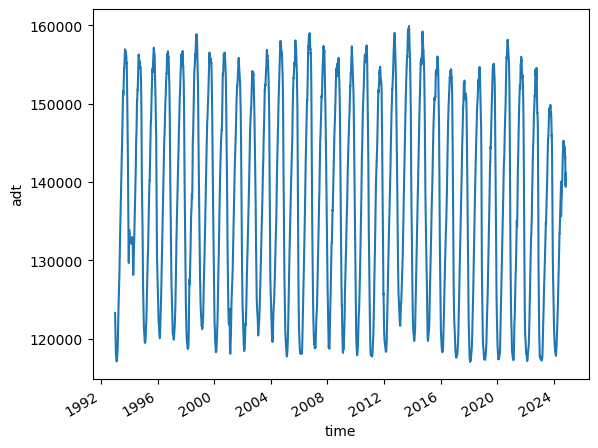

In [7]:
ds.adt.isnull().sum(["latitude", "longitude"]).compute().plot()

In [8]:
#check that all time steps are equal and there are no gaps:
print(ds.time.diff("time").to_pandas().describe())

count              11634
mean     1 days 00:00:00
std      0 days 00:00:00
min      1 days 00:00:00
25%      1 days 00:00:00
50%      1 days 00:00:00
75%      1 days 00:00:00
max      1 days 00:00:00
dtype: object


In [9]:
ds = ds.adt.isel(time=slice(None, None, 5))
ds = ds.astype("float32")
ds.nbytes / 1e9

3.2168448

In [10]:
ds.drop_encoding().to_netcdf("../../data/adt_5d.nc", format="NETCDF3_64BIT")

In [11]:
!ls -lah ../../data/
!rm -rf tmp/

total 36M
drwxr-xr-x 2 jovyan jovyan   27 Nov  8 09:37 .
drwxr-xr-x 5 jovyan jovyan   85 Nov  8 09:32 ..
-rw-r--r-- 1 jovyan jovyan 3.0G Nov  8 09:38 adt_5d.nc
